# **Research Assistant:**

This project creates an automated assistant that generates a research report based on analyst personas and sources, leveraging LangGraph's capabilities for memory, human-in-the-loop feedback, and controllability.

**Project Overview**
This project aims to automate research workflows using LangGraph and an LLM (Large Language Model) like OpenAI's GPT model. Here's the basic workflow:

* **Analyst Creation:** We create analyst personas focused on specific sub-topics of the main research topic.

* **Human Feedback:** Human reviewers can adjust analyst personas to better meet research goals.

* **Conduct Interviews:** Each analyst conducts a simulated interview with an expert on their sub-topic.

* **Report Generation:** The assistant combines insights from each interview to create a cohesive report with an introduction, main content, and conclusion.

## **Set Up Everything:**

In [3]:
%%capture --no-stderr
%pip install -qU langgraph langchain_core langchain_community langchain-groq tavily-python wikipedia streamlit pyngrok

In [4]:
# For Colab, use this:
from google.colab import userdata
TAVILY_API_KEY = userdata.get("TAVILY_API_KEY")
GROQ_API_KEY = userdata.get("GROQ_API_KEY")

In [5]:
import os
os.environ["TAVILY_API_KEY"] = TAVILY_API_KEY
os.environ["GROQ_API_KEY"] = GROQ_API_KEY

In [80]:
from langchain_groq import ChatGroq

# Initialize the Groq model
llm = ChatGroq(
    model="llama3-groq-70b-8192-tool-use-preview",
    temperature=0,
)

## **Analyst Creation with Human-In-A-Loop:**

**Defining Analyst Data Structure**

Let's define the structure of the "analysts" who will conduct the research. Each analyst is a simulated persona with specific attributes such as a name, role, affiliation, and focus within the context of the research topic.

In [81]:
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"


The Analyst class is a pydantic model that represents each analyst's profile. This profile includes details such as:

* **affiliation:** The organization or institution the analyst is associated with. This field gives context to the analyst’s perspective, as affiliations often influence viewpoints and biases.

* **name:** The analyst's name, which personalizes each profile.

* **role:** The analyst's role within the research topic. This could reflect the analyst’s expertise or specific perspective, such as "Economist" or "Data Scientist".

* **description:** A detailed description of the analyst’s focus, concerns, and motives within the research context. This is meant to add depth to each persona, specifying what the analyst is looking for, why they care about this topic, and how they may approach it.

**@property decorator:** Turns the persona method into a read-only attribute, so it can be accessed like an attribute (analyst.persona) rather than a method (analyst.persona()).

**persona Property:**

* **Purpose:** This property provides a formatted string representation of the analyst’s profile.

* **Functionality:** When called, it returns a detailed string combining all the attributes of the analyst in a readable format. This is useful when generating prompts for the language model (LLM) because it provides a clear and structured summary of the analyst’s persona.


**Example of persona**

If an analyst’s attributes are:
```
name="Alice Smith"
role="Market Analyst"
affiliation="TechInsights Inc."
description="Analyzes market trends in AI and ML technologies."
```
Then persona would show output for print(analyst.persona)
```
Name: Alice Smith
Role: Market Analyst
Affiliation: TechInsights Inc.
Description: Analyzes market trends in AI and ML technologies.
```

**Defining the Perspectives Class**

In [82]:
class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

**Purpose:** The Perspectives class wraps multiple Analyst instances into a single list. This makes it easy to manage a group of analysts within one object.

**Attributes:**

* **analysts:** A list of Analyst objects. Each Analyst object represents an individual analyst with a unique profile.

**Example Usage of Perspectives**
```
perspectives = Perspectives(analysts=[
    Analyst(name="Alice Smith", role="Market Analyst", affiliation="TechInsights Inc.", description="Analyzes market trends in AI and ML technologies."),
    Analyst(name="John Doe", role="Policy Analyst", affiliation="Global Policy Institute", description="Focuses on policy implications of AI advancements."),
])
```
This object now contains two Analyst objects in the analysts list, each representing a unique persona within the research assistant.

**Defining the GenerateAnalystsState TypedDict**

In [83]:
class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

The GenerateAnalystsState class is a TypedDict that holds the state information required for generating analysts. This dictionary defines the structure of data that will be used by our LangGraph flow to create analyst personas. Each key-value pair in this dictionary has a specific purpose in the research assistant's workflow:

* **topic:** A string representing the main research topic. This topic will guide the focus of each analyst persona, ensuring that all generated analysts are relevant to the primary subject.

* **max_analysts:** An integer indicating the maximum number of analysts to generate. This helps control the number of personas generated based on user preference or system constraints.

* **human_analyst_feedback:** A string to capture any feedback provided by a human reviewer. This feedback allows human intervention to refine or adjust the analyst personas before proceeding with research.

* **analysts:** A list of Analyst objects, each representing an individual persona. This is where the generated analysts will be stored after they are created by the system.

**Example Usage of GenerateAnalystsState**
```
state = GenerateAnalystsState(
    topic="The impact of AI on healthcare",
    max_analysts=3,
    human_analyst_feedback="Add a perspective from a regulatory official",
    analysts=[]
)
```
This GenerateAnalystsState instance sets up the parameters for creating analysts on the topic "The impact of AI on healthcare." It requests up to 3 analysts and includes human feedback asking for a regulatory perspective.

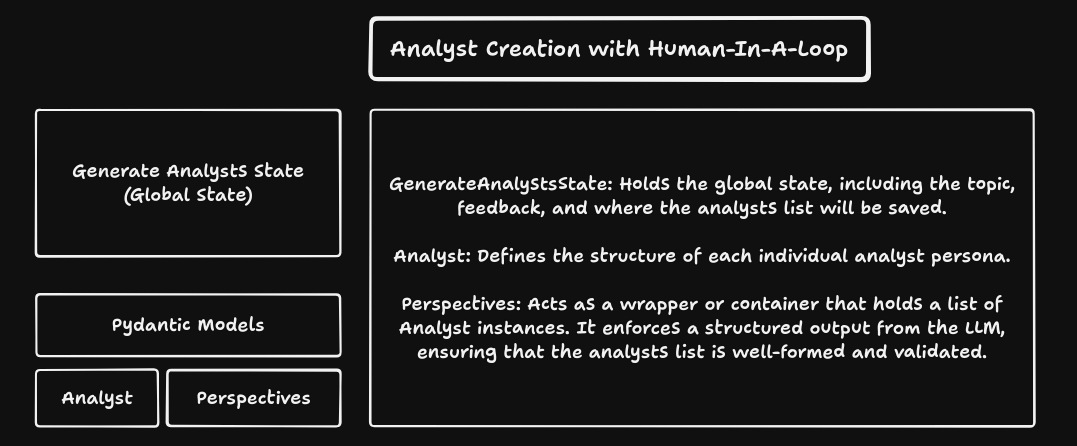

In [84]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

**Defining the Analyst Instructions**

In [85]:
analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}

2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts:
{human_analyst_feedback}

3. Determine the most interesting themes based upon documents and / or feedback above.

4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

* The analyst_instructions string provides a set of guidelines for the AI to generate analyst personas.

* This prompt template helps the AI create relevant, targeted analyst profiles that align with the research goals.

**Create Analysts Node**

In [86]:
def create_analysts(state: GenerateAnalystsState):
    """ Create analysts """

    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                 human_analyst_feedback=human_analyst_feedback,
                                                 max_analysts=max_analysts)

    # Generate question
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])

    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

This function, create_analysts, generates a set of analyst personas based on the topic, maximum number of analysts, and any human feedback provided.

**Extracting State Values:**
* **topic:** The main research topic to guide the analysts' focus.
* **max_analysts:** The maximum number of analyst personas to create.
* **human_analyst_feedback:** Optional feedback from a human reviewer, used to refine the analysts' themes and focus areas.

**Configuring the LLM for Structured Output:**
* **structured_llm = llm.with_structured_output(Perspectives):** This configures the LLM to produce output in a structured format defined by the Perspectives class. This ensures that the generated output matches the expected format for our analysts (a list of Analyst objects with their roles and affiliations).

**Formatting the System Message:**

* **system_message = analyst_instructions.format(...):** Here, the analyst_instructions string is formatted with the topic, human_analyst_feedback, and max_analysts. This creates a complete instruction set that the LLM will use to generate the analysts.

**Invoking the LLM with Instructions:**

**analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")]):**

* A SystemMessage is created with the formatted system_message content. This message provides the LLM with the context and instructions for generating analysts.
* A HumanMessage is also included, prompting the LLM to "Generate the set of analysts." This simulates a prompt from a human operator, instructing the AI to carry out the task.
* The invoke method calls the LLM to generate the analysts based on these instructions, returning a structured response.

**Returning the Generated Analysts:**

* **return {"analysts": analysts.analysts}:** After the LLM generates the list of analysts, the function returns this list in a dictionary with the key "analysts". This dictionary will update the GenerateAnalystsState, storing the generated analysts for further processing in the workflow.

**Human Feedback Node with human_feedback Function**

In [87]:
def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

The human_feedback function serves as a no-operation (no-op) node. This function does not perform any actions but acts as a breakpoint in the graph where human feedback can be added.

**Conditional Control**

In [88]:
def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"

    # Otherwise end
    return END

The should_continue function is a conditional function that determines the next step in the workflow based on the presence of human feedback. This function controls the flow of the LangGraph and decides if the workflow should loop back to re-create analysts or proceed to the end.

**Check for Human Feedback:**

**human_analyst_feedback=state.get('human_analyst_feedback', None):**
* This line retrieves the human feedback from the GenerateAnalystsState. If feedback is present, it indicates that a human reviewer has requested modifications to the analysts.

**Conditional Logic:**

* **if human_analyst_feedback:** If feedback exists, this function returns "create_analysts", directing the workflow to loop back to the create_analysts function. This allows the system to re-run the analyst creation process with the updated feedback, refining the analyst personas.
* **return END:** If no feedback is present, the function returns END, indicating that the analyst creation process is complete, and the workflow should proceed to its conclusion

**Build The Graph**

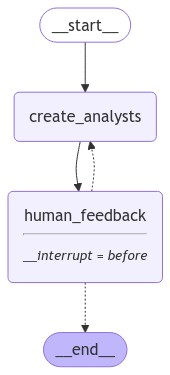

In [89]:
builder = StateGraph(GenerateAnalystsState)

builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)

builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

**Invoke The Graph**

In [90]:
# Input
max_analysts = 3
topic = "The Future of AI Agents"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Alex Johnson
Affiliation: Tech Innovations Inc.
Role: Lead AI Researcher
Description: Focuses on the development of AI agents and their potential impact on society.
--------------------------------------------------
Name: Dr. Emily Clark
Affiliation: FutureTech Lab
Role: Ethics Specialist
Description: Explores the ethical implications of AI agents and how they might shape our future.
--------------------------------------------------
Name: Michael Brown
Affiliation: Global AI Forum
Role: Economic Analyst
Description: Analyzes the economic impact of AI agents on various industries.
--------------------------------------------------


**Get Current State and Identify Next Node**

In [91]:
state = graph.get_state(thread)
state.next

('human_feedback',)

**Update State with Human Feedback at the human_feedback Node**

In [92]:
graph.update_state(thread, {"human_analyst_feedback":
                            "Add in someone from a startup to add an entrepreneur perspective"}, as_node="human_feedback")


{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9f5b5-088a-6385-8002-9827974e0e0a'}}

This update effectively instructs the workflow to go back to the create_analysts node, as should_continue will detect the presence of human_analyst_feedback and redirect the flow accordingly.

**Resume Graph Execution to Process the Updated Feedback**

In [93]:
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Alex Johnson
Affiliation: Tech Innovations Inc.
Role: Lead AI Researcher
Description: Focuses on the development of AI agents and their potential impact on society.
--------------------------------------------------
Name: Dr. Emily Clark
Affiliation: FutureTech Lab
Role: Ethics Specialist
Description: Explores the ethical implications of AI agents and how they might shape our future.
--------------------------------------------------
Name: Michael Brown
Affiliation: Global AI Forum
Role: Economic Analyst
Description: Analyzes the economic impact of AI agents on various industries.
--------------------------------------------------
Name: Alex Johnson
Affiliation: Tech Innovators Inc.
Role: Lead Developer
Description: Focuses on the development of AI agents for various industries, with a keen interest in how AI can revolutionize business operations.
--------------------------------------------------
Name: Dr. Emily Chen
Affiliation: FutureTech Research
Role: Ethics Researcher
Descr

This loop resumes the workflow from where it left off, now incorporating the newly provided human feedback. It processes each event (or node execution) in the graph.

**Finalize the Analysts by Clearing Feedback**

This action effectively "locks in" the analysts, allowing the workflow to complete without further modifications.

In [94]:
further_feedback = None
graph.update_state(thread, {"human_analyst_feedback":
                            further_feedback}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9f5b5-100c-6a18-8004-a9613ce4e557'}}

**Finalize Graph Execution and Check Each Node’s Progression**

This confirms the successful execution of each node, ending when the graph reaches the END node.

In [95]:
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

**Retrieve the Final State and Display the Analysts**

After the graph reaches END, this code retrieves the final state, allowing us to inspect the finalized list of analysts.

In [96]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')

**Print the Final List of Analysts**

In [97]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Name: Alex Johnson
Affiliation: Tech Innovators Inc.
Role: Lead Developer
Description: Focuses on the development of AI agents for various industries, with a keen interest in how AI can revolutionize business operations.
--------------------------------------------------
Name: Dr. Emily Chen
Affiliation: FutureTech Research
Role: Ethics Researcher
Description: Examines the ethical implications of AI agents and their potential impact on society.
--------------------------------------------------
Name: Jamie Lee
Affiliation: StartupAI
Role: Founder
Description: A pioneer in integrating AI agents into startup ecosystems, focusing on scalability and adaptability.
--------------------------------------------------


## **Interview Phase:**

### **Generate Questions**

Now let's add interview component in our research assistant.

Here, each analyst will conduct an interview with an expert to gather specific insights on their assigned topic. This process involves generating questions that the analyst will ask, storing responses from the expert, and controlling the flow of the conversation to ensure relevant information is gathered.

**Overview and Objective**
In this section, we are creating an interactive interview process for our analysts:

* **Interview State Setup:** We define the structure of the InterviewState, where all data related to the interview (such as context, analyst details, and conversation transcript) is stored.
* **Generate Interview Questions:** Using a prompt, we guide each analyst to ask relevant and insightful questions to an expert.
* **Goal:** The objective is to conduct an interview that yields specific and non-obvious insights into the topic, which will later be used in the research report.

**Define InterviewState - The Data Structure for Interviews**

In [98]:
import operator
from typing import Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number of conversation turns allowed
    context: Annotated[list, operator.add] # Collection of documents or insights related to the topic
    analyst: Analyst # Analyst conducting the interview
    interview: str # Stores the full transcript of the interview
    sections: list # Final list to be used with Send() API

**InterviewState:** This is a specialized data structure, based on MessagesState, that holds information necessary for conducting and managing an interview.

**Attributes:**

* **max_num_turns:** Defines the maximum number of question-and-answer turns allowed in the conversation. This limits the length of the interview.
* **context:** A list of source documents or context for the topic that the analyst can refer to. The use of Annotated[list, operator.add] indicates that multiple items (e.g., documents or notes) can be aggregated here as the interview progresses.
* **analyst:** Stores the Analyst instance conducting the interview. This includes the persona, name, affiliation, and other details of the analyst, which guide how they approach the interview.
* **interview:** This will eventually contain the full transcript of the interview for future reference or report generation.
* **sections:** A list used to hold structured parts of the interview, which can be sent to other nodes for further processing (e.g., compiling the report).

This structure allows us to store all interview-related information in one place, making it easy to retrieve, update, and manage during the workflow.

**Define SearchQuery - Structure for Generating Search Queries**

In [99]:
class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

**Purpose:** SearchQuery is a simple model that defines the structure of a search query. This class can be used when analysts need to generate a search query for retrieving additional information.

**Attribute:**
search_query: Holds the actual search query as a string. This query can be used to pull in relevant information from databases, web searches, or other external sources.

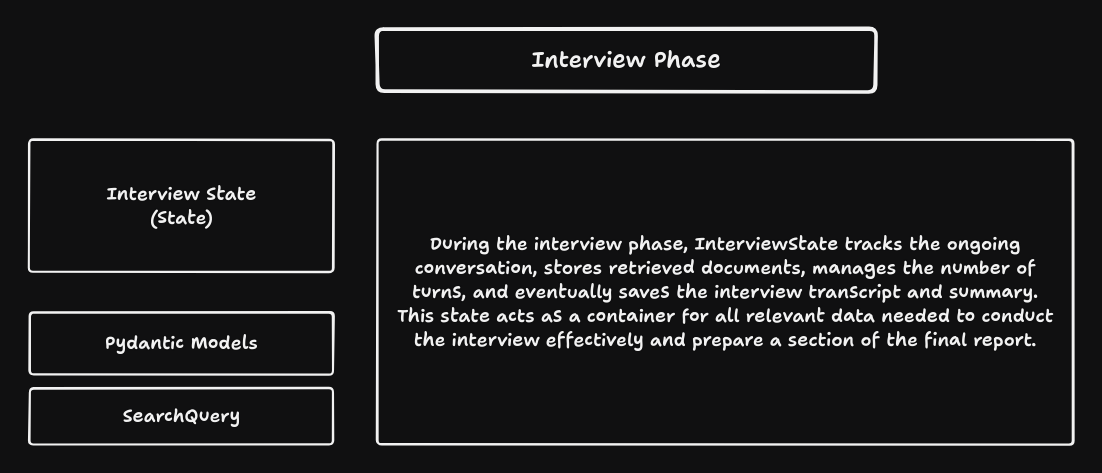

**Define Instructions for Generating Questions**

In [100]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic.

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.

2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}

Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.

When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

**Purpose:** This prompt provides detailed instructions to the analyst (AI-driven) on how to conduct the interview.

**Generate Questions for the Interview - The generate_question Function**

In [101]:
def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Write messages to state
    return {"messages": [question]}

**Purpose:** This function generates a question for the analyst to ask the expert, based on the state and the prompt instructions.

**Extract State Information:**
**analyst:** Retrieves the analyst's persona from InterviewState, which includes the analyst’s role, focus, and approach to the topic.
messages: Holds the conversation history (questions and answers exchanged so far).

**Format the Prompt:**
**system_message:** The question_instructions are formatted with the specific persona of the analyst (analyst.persona). This fills in {goals} in the prompt, making it relevant to the analyst's assigned topic.

**Generate the Question:**
**llm.invoke([...]):** The language model (e.g., ChatGPT or similar) is invoked with the system_message and the existing messages (conversation history). The model then generates a question based on the prompt and the ongoing conversation.

**Return the Question:**
**return {"messages": [question]}:** The generated question is appended to the conversation (messages), updating the interview state.
This function enables the analyst to generate contextually relevant questions that build on prior responses, creating a natural flow to the interview.

### **Generate Answer: Parallelization**

Let's further develop our research assistant by setting up the process for conducting in-depth interviews, where each analyst gathers information from various sources (like web searches and Wikipedia) to answer specific questions. The information gathered is then used to answer the analyst’s questions, store the interview transcript, and write a summary section of the interview.

**Gathering Information from Multiple Sources in Parallel:**

The purpose here is to allow the system to search for information across multiple sources simultaneously to provide comprehensive answers. Parallelization is achieved by calling different sources like TavilySearch (a web search tool) and WikipediaLoader independently but as part of the same process.

In [102]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

In [103]:
# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

**Search Query Generation Instructions**

In [104]:
from langchain_core.messages import get_buffer_string

# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert.

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.

First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

**Purpose:** Provides instructions for generating a search query based on the conversation so far, with a focus on the analyst's most recent question.

**search_web - Search Web for Relevant Information**

In [105]:
def search_web(state: InterviewState):
    """ Retrieve docs from web search """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

**Purpose:** Searches the web for information related to the analyst’s question.

* **Generate Search Query:** Uses the language model (llm) to create a search query based on the last question in state['messages'].

* **Invoke Search:** Passes the generated query to tavily_search, a web search tool, to retrieve relevant documents.

* **Format Results:** Formats the retrieved documents by combining their content and URLs for easy reference.

* **Return:** The formatted documents are returned as context, which will be used by the expert to answer the question.

**search_wikipedia - Search Wikipedia for Relevant Information**

In [106]:
def search_wikipedia(state: InterviewState):
    """ Retrieve docs from wikipedia """

    # Search query
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])

    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, load_max_docs=2).load()

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]}

**Purpose:** Searches Wikipedia for information related to the question.

* **Generate Search Query:** Similar to search_web, it generates a search query based on the latest question.

* **Invoke Search:** Queries Wikipedia for up to two documents that match the search query.

* **Format Results:** Formats the retrieved Wikipedia content, including source metadata and page information.

* **Return:** Returns the formatted documents as context for use in answering the question.

**Instructions for Generating an Answer**

In [107]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}.

You goal is to answer a question posed by the interviewer.

To answer question, use this context:

{context}

When answering questions, follow these guidelines:

1. Use only the information provided in the context.

2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1].

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc

6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list:

[1] assistant/docs/llama3_1.pdf, page 7

And skip the addition of the brackets as well as the Document source preamble in your citation."""

**Purpose:** Instructs the expert on how to answer the analyst’s question based on the retrieved context.

**generate_answer - Generate Answer Based on Retrieved Information**

In [108]:
def generate_answer(state: InterviewState):
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)

    # Name the message as coming from the expert
    answer.name = "expert"

    # Append it to state
    return {"messages": [answer]}

**Purpose:** Uses the gathered context to generate an answer to the analyst's question.

**Steps:**

* **Prepare the Prompt:** Formats answer_instructions to include the analyst's goals and the relevant context.

* **Generate Answer:** The language model generates an answer based on the system message and conversation history.

* **Label Answer:** Labels the response as coming from the "expert" for clarity.

* **Return:** Adds the answer to the conversation state.

**save_interview - Save the Interview Transcript**

In [109]:
def save_interview(state: InterviewState):
    """ Save interviews """

    # Get messages
    messages = state["messages"]

    # Convert interview to a string
    interview = get_buffer_string(messages)

    # Save to interviews key
    return {"interview": interview}

**Purpose:** Converts the entire conversation (messages) into a single string and saves it as interview.

**Usage:** This saved transcript can later be used for summarizing or for generating a report.

**route_messages - Control the Interview Flow**

In [110]:
def route_messages(state: InterviewState,
                   name: str = "expert"):

    """ Route between question and answer """

    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]

    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"

**Purpose:** Manages the flow of the conversation, deciding whether to continue or end the interview.

**Logic:**
* **Turn Limit:** Checks if the maximum conversation turns have been reached.
* **End Condition:** If the final question signals the end of the conversation, the interview is saved; otherwise, it loops back to asking another question.

**Instructions for Generating a Report Section**

In [111]:
section_writer_instructions = """You are an expert technical writer.

Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents:
- The name of each source document is at the start of the document, with the <Document tag.

2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers

3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst:
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents

6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/

8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

This serves as a comprehensive guide for the AI to generate a report section that:

* Is well-structured and formatted with Markdown.
* Is concise, engaging, and specific to the analyst's focus.
* Includes a clear list of sources, referenced consistently throughout the section.

**write_section - Summarize the Interview for the Report**

In [112]:
def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]

    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")])

    # Append it to state
    return {"sections": [section.content]}

**Purpose:** Creates a summary section of the interview to be included in the research report.

**Steps:**

* **Prepare the Instructions:** Formats section_writer_instructions with the analyst's description.
* **Generate Section:** Uses the language model to create a well-structured summary based on the interview content and context.
* **Store Section:** The generated summary is added to sections, which will be used in the final report.

**Setting up the Graph for Interview Flow**

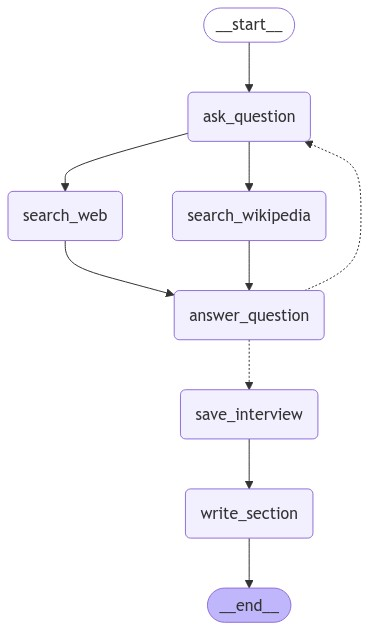

In [113]:
# Add nodes and edges
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

**How we can pick one Analyst**

In [114]:
# Pick one analyst
analysts[0]

Analyst(affiliation='Tech Innovators Inc.', name='Alex Johnson', role='Lead Developer', description='Focuses on the development of AI agents for various industries, with a keen interest in how AI can revolutionize business operations.')

### **Execution**

In [115]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": "1"}}
interview = interview_graph.invoke({"analyst": analysts[0], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

## Transforming Businesses with AI Agents: A New Frontier in Automation

### Summary

The development of AI agents is revolutionizing business operations by automating complex processes and enhancing decision-making capabilities. These agents are not just chatbots or content generators; they can take action, complete tasks, and drive real-world results. To leverage the full potential of AI agents, businesses must start exploring their capabilities now. This includes validating that pilot projects are resulting in outcomes aligned with business objectives before scaling AI agents across broader functions. The integration of AI agents in various industries is paving the way for a more transparent, auditable, and sustainable use of AI, which will transform businesses on a large scale and speed.

### Sources
[1] https://www.techradar.com/pro/the-rise-of-agentic-ai-what-does-it-mean-for-businesses
[2] https://www.forbes.com/councils/forbesbusinesscouncil/2024/10/01/the-rise-of-ai-agents-unlocking-their-full-potential/
[3] https://en.wikipedia.org/wiki/OpenAI
[4] https://en.wikipedia.org/wiki/AI_boom
[5] https://en.wikipedia.org/wiki/AI_takeover
[6] https://en.wikipedia.org/wiki/Computer-integrated_manufacturing
[7] https://en.wikipedia.org/wiki/White-collar_machines
[8] https://en.wikipedia.org/wiki/Autonomous_car
[9] https://en.wikipedia.org/wiki/AI-generated_content
[10] https://www.techradar.com/pro/the-rise-of-agentic-ai-what-does-it-mean-for-businesses
[11] https://www.forbes.com/councils/forbesbusinesscouncil/2024/10/01/the-rise-of-ai-agents-unlocking-their-full-potential/
[12] https://en.wikipedia.org/wiki/OpenAI
[13] https://en.wikipedia.org/wiki/AI_boom
[14] https://en.wikipedia.org/wiki/AI_takeover
[15] https://en.wikipedia.org/wiki/Computer-integrated_manufacturing
[16] https://en.wikipedia.org/wiki/White-collar_machines
[17] https://en.wikipedia.org/wiki/Autonomous_car
[18] https://en.wikipedia.org/wiki/AI-generated_content
[19] https://www.techradar.com/pro/the-rise-of-agentic-ai-what-does-it-mean-for-businesses
[20] https://www.forbes.com/councils/forbesbusinesscouncil/2024/10/01/the-rise-of-ai-agents-unlocking-their-full-potential/
[21] https://en.wikipedia.org/wiki/OpenAI
[22] https://en.wikipedia.org/wiki/AI_boom
[23] https://en.wikipedia.org/wiki/AI_takeover
[24] https://en.wikipedia.org/wiki/Computer-integrated_manufacturing
[25] https://en.wikipedia.org/wiki/White-collar_machines
[26] https://en.wikipedia.org/wiki/Autonomous_car
[27] https://en.wikipedia.org/wiki/AI-generated_content
[28] https://www.techradar.com/pro/the-rise-of-agentic-ai-what-does-it-mean-for-businesses
[29] https://www.forbes.com/councils/forbesbusinesscouncil/2024/10/01/the-rise-of-ai-agents-unlocking-their-full-potential/
[30] https://en.wikipedia.org/wiki/OpenAI
[31] https://en.wikipedia.org/wiki/AI_boom
[32] https://en.wikipedia.org/wiki/AI_takeover
[33] https://en.wikipedia.org/wiki/Computer-integrated_manufacturing
[34] https://en.wikipedia.org/wiki/White-collar_machines
[35] https://en.wikipedia.org/wiki/Autonomous_car
[36] https://en.wikipedia.org/wiki/AI-generated_content
[37] https://www.techradar.com/pro/the-rise-of-agentic-ai-what-does-it-mean-for-businesses
[38] https://www.forbes.com/councils/forbesbusinesscouncil/2024/10/01/the-rise-of-ai-agents-unlocking-their-full-potential/
[39] https://en.wikipedia.org/wiki/OpenAI
[40] https://en.wikipedia.org/wiki/AI_boom
[41] https://en.wikipedia.org/wiki/AI_takeover
[42] https://en.wikipedia.org/wiki/Computer-integrated_manufacturing
[43] https://en.wikipedia.org/wiki/White-collar_machines
[44] https://en.wikipedia.org/wiki/Autonomous_car
[45] https://en.wikipedia.org/wiki/AI-generated_content
[46] https://www.techradar.com/pro/the-rise-of-agentic-ai-what-does-it-mean-for-businesses
[47] https://www.forbes.com/councils/forbesbusinesscouncil/2024/10/01/the-rise-of-ai-agents-unlocking-their-full-potential/
[48] https://en.wikipedia.org/wiki/OpenAI
[49] https://en.wikipedia.org/wiki/AI_boom
[50] https://en.wikipedia.org/wiki/AI_takeover
[51] https://en.wikipedia.org/wiki/Computer-integrated_manufacturing
[52] https://en.wikipedia.org/wiki/White-collar_machines
[53] https://en.wikipedia.org/wiki/Autonomous_car
[54] https://en.wikipedia.org/wiki/AI-generated_content
[55] https://www.techradar.com/pro/the-rise-of-agentic-ai-what-does-it-mean-for-businesses
[56] https://www.forbes.com/councils/forbesbusinesscouncil/2024/10/01/the-rise-of-ai-agents-unlocking-their-full-potential/
[57] https://en.wikipedia.org/wiki/OpenAI
[58] https://en.wikipedia.org/wiki/AI_boom
[59] https://en.wikipedia.org/wiki/AI_takeover
[60] https://en.wikipedia.org/wiki/Computer-integrated_manufacturing
[61] https://en.wikipedia.org/wiki/White-collar_machines
[62] https://en.wikipedia.org/wiki/Autonomous_car
[63] https://en.wikipedia.org/wiki/AI-generated_content
[64] https://www.techradar.com/pro/the-rise-of-agentic-ai-what-does-it-mean-for-businesses
[65] https://www.forbes.com/councils/forbesbusinesscouncil/2024/10/01/the-rise-of-ai-agents-unlocking-their-full-potential/
[66] https://en.wikipedia.org/wiki/OpenAI
[67] https://en.wikipedia.org/wiki/AI_boom
[68] https://en.wikipedia.org/wiki/AI_takeover
[69] https://en.wikipedia.org/wiki/Computer-integrated_manufacturing
[70] https://en.wikipedia.org/wiki/White-collar_machines
[71] https://en.wikipedia.org/wiki/Autonomous_car
[72] https://en.wikipedia.org/wiki/AI-generated_content
[73] https://www.techradar.com/pro/the-rise-of-agentic-ai-what-does-it-mean-for-businesses
[74] https://www.forbes.com/councils/forbesbusinesscouncil/2024/10/01/the-rise-of-ai-agents-unlocking-their-full-potential/
[75] https://en.wikipedia.org/wiki/OpenAI
[76] https://en.wikipedia.org/wiki/AI_boom
[77] https://en.wikipedia.org/wiki/AI_takeover
[78] https://en.wikipedia.org/wiki/Computer-integrated_manufacturing
[79] https://en.wikipedia.org/wiki/White-collar_machines
[80] https://en.wikipedia.org/wiki/Autonomous_car
[81] https://en.wikipedia.org/wiki/AI-generated_content
[82] https://www.techradar.com/pro/the-rise-of-agentic-ai-what-does-it-mean-for-businesses
[83] https://www.forbes.com/councils/forbesbusinesscouncil/2024/10/01/the-rise-of-ai-agents-unlocking-their-full-potential/
[84] https://en.wikipedia.org/wiki/OpenAI
[85] https://en.wikipedia.org/wiki/AI_boom
[86] https://en.wikipedia.org/wiki/AI_takeover
[87] https://en.wikipedia.org/wiki/Computer-integrated_manufacturing
[88] https://en.wikipedia.org/wiki/White-collar_machines
[89] https://en.wikipedia.org/wiki/Autonomous_car
[90] https://en.wikipedia.org/wiki/AI-generated_content
[91] https://www.techradar.com/pro/the-rise-of-agentic-ai-what-does-it-mean-for-businesses
[92] https://www.forbes.com/councils/forbesbusinesscouncil/2024/10/01/the-rise-of-ai-agents-unlocking-their-full-potential/
[93] https://en.wikipedia.org/wiki/OpenAI
[94] https://en.wikipedia.org/wiki/AI_boom
[95] https://en.wikipedia.org/wiki/AI_takeover
[96] https://en.wikipedia.org/wiki/Computer-integrated_manufacturing
[97] https://en.wikipedia.org/wiki/White-collar_machines
[98] https://en.wikipedia.org/wiki/Autonomous_car
[99] https://en.wikipedia.org/wiki/AI-generated_content
[100] https://www.techradar.com/pro/the-rise-of-agentic-ai-what-does-it-mean-for-businesses
[101] https://www.forbes.com/councils/forbesbusinesscouncil/2024/10/01/the-rise-of-ai-agents-unlocking-their-full-potential/

## **Parallelze interviews: Map-Reduce**

This section of code finalizes our research assistant project by adding a mechanism to conduct multiple interviews in parallel (using a map-reduce approach) and then synthesize the findings into a single, cohesive report. The main objectives here are:

* Conduct parallel interviews for each analyst using a map step.
* Aggregate the results from all interviews into a final report using a reduce step.
* Add an introduction and conclusion to complete the report.

**Define the State for the Research Graph**

In [116]:
from typing import List, Annotated
from typing_extensions import TypedDict
import operator

class ResearchGraphState(TypedDict):
    topic: str  # Research topic
    max_analysts: int  # Number of analysts
    human_analyst_feedback: str  # Human feedback
    analysts: List[Analyst]  # List of analysts asking questions
    sections: Annotated[list, operator.add]  # Store sections from each analyst
    introduction: str  # Introduction for the final report
    content: str  # Main content of the final report
    conclusion: str  # Conclusion for the final report
    final_report: str  # Final compiled report

**ResearchGraphState:** This class defines the overall structure of the data that flows through our research graph. It includes:

* **topic:** The central topic of the research.
* **max_analysts:** The number of analysts conducting research.
* **human_analyst_feedback:** Feedback from humans to refine the analyst personas or research approach.
* **analysts:** A list of analyst personas.
* **sections:** This is a list that accumulates sections from each analyst, representing their findings from the interview. The operator.add annotation means sections from parallel interviews will be combined.
* **introduction, content, and conclusion:** These represent the introduction, main body, and conclusion of the report.
* **final_report:** The completed report containing all parts.

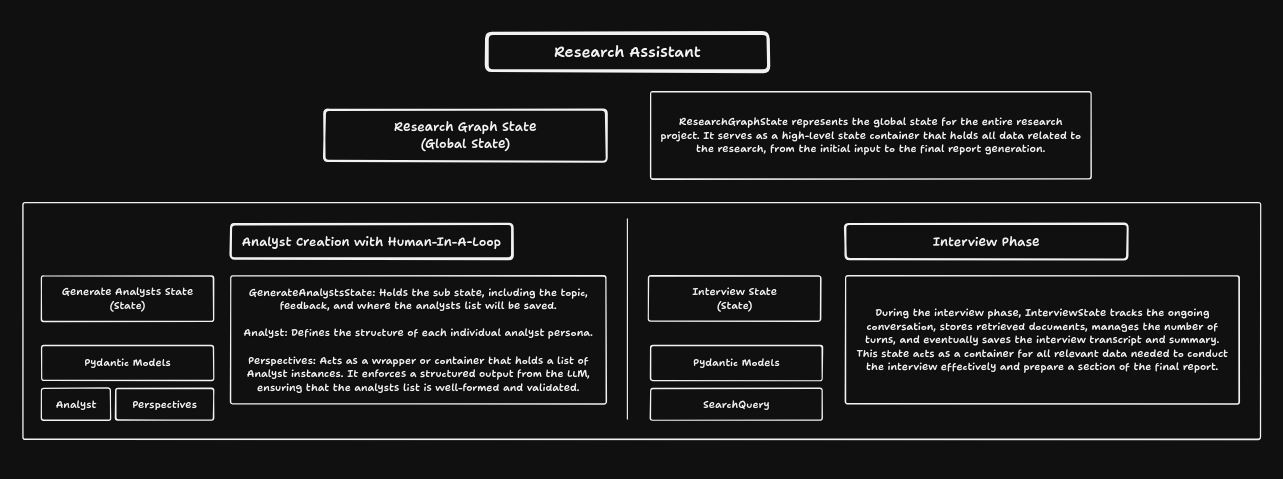

**Initiate Parallel Interviews (Map Step)**

In [117]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

**Purpose:** This function initializes the map step, where each analyst conducts an interview in parallel. It utilizes LangGraph’s Send() API to distribute these interviews simultaneously.

**Logic:**
* **Check for human feedback:** If there’s feedback in human_analyst_feedback, it returns to create_analysts to adjust the analyst list.

* **Start Parallel Interviews:** If no further feedback is needed, it sends each analyst to the conduct_interview subgraph with a starter message for each interview. This process runs interviews for all analysts in parallel, maximizing efficiency.

**Write instructions for writing the report**

In [118]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic:

{topic}

You have a team of analysts. Each analyst has done two things:

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task:

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos.
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:

1. Use markdown formatting.
2. Include no pre-amble for the report.
3. Use no sub-heading.
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from:

{context}"""

**Write the Report Body (Reduce Step)**

In [119]:
def write_report(state: ResearchGraphState):
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])

    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")])
    return {"content": report.content}

**Purpose:** This function aggregates the findings from all analysts’ sections into a single report body (the reduce step).

**Logic:**
* **Concatenate Sections:** Joins each section from sections (generated by each analyst) into one large string.
* **Summarize and Format:** Passes this concatenated content to the language model using the report_writer_instructions, which guides the model to create a cohesive report.
* **Output:** Returns a single content string summarizing the analysts' insights without individual analyst names.

**Write Instructions For Introductions & Conclusions**

In [120]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting.

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header.

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

**Write Introduction Function**

In [121]:
def write_introduction(state: ResearchGraphState):
    # Prepare the introduction
    sections = state["sections"]
    topic = state["topic"]
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    intro = llm.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")])
    return {"introduction": intro.content}

**Write Conclusion Funtion**

In [122]:
def write_conclusion(state: ResearchGraphState):
    # Prepare the conclusion
    sections = state["sections"]
    topic = state["topic"]
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)
    conclusion = llm.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")])
    return {"conclusion": conclusion.content}

**Purpose:** These two functions generate the introduction and conclusion for the report.

**Logic:**
* **Prepare Sections:** Combines all sections to provide the necessary context for writing a summary or recap.
* **Instructions for Intro/Conclusion:** Uses intro_conclusion_instructions, formatted with the topic and section content, guiding the model to create an introduction or conclusion.
* **Output:** Returns either an introduction or conclusion, depending on which function is invoked.

**Finalize the Report**

In [123]:
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

**Purpose:** This function consolidates the introduction, body, and conclusion into a finalized report.

**Logic:**
* **Trim Content:** Strips any redundant headers from the report content.
* **Separate Sources:** Checks for sources in the body and, if found, moves them to the end.
* **Assemble Final Report:** Combines the introduction, main content, and conclusion into a single document, adding sources at the end.
* **Output:** Returns the final_report string, which is the fully formatted and finalized document.

### **Building the Research Graph**

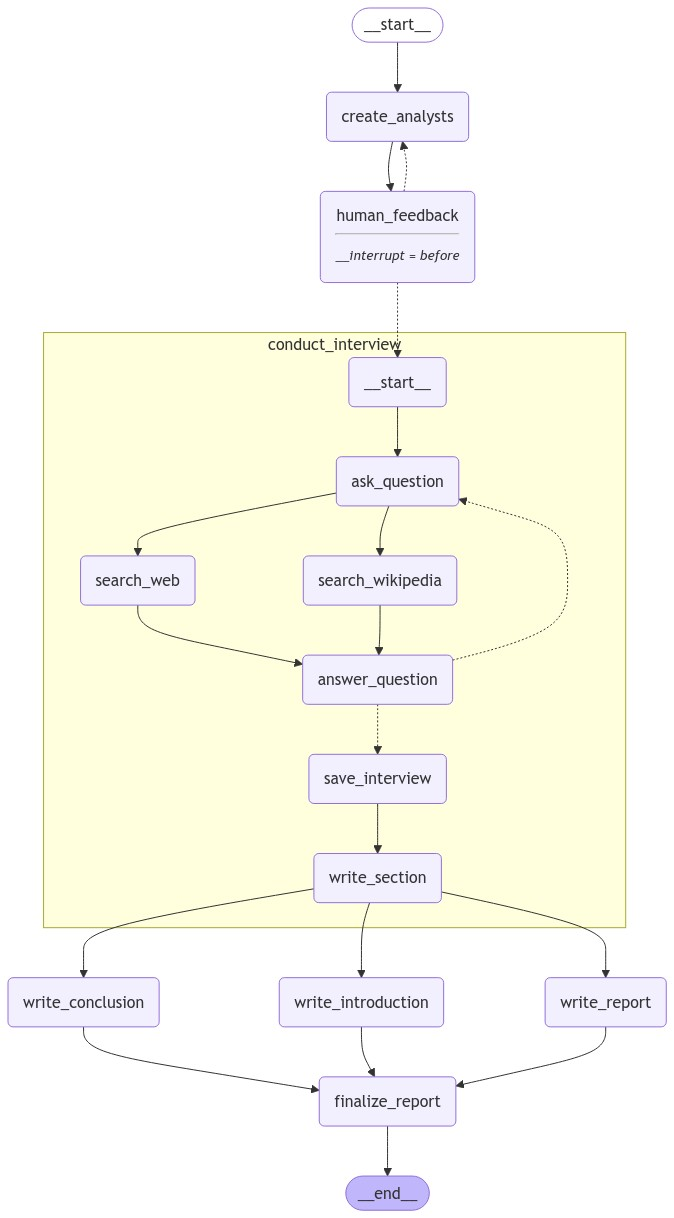

In [124]:
# Add nodes and edges
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

## **Run The Completed Graph**

**Define Inputs and Initialize the Graph**

In [140]:
# Inputs
max_analysts = 3
topic = "Project Management"
thread = {"configurable": {"thread_id": "1"}}

**Run the Graph Until the First Interruption**

In [141]:
# Run the graph until the first interruption
for event in graph.stream({"topic": topic, "max_analysts": max_analysts}, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Alex Johnson
Affiliation: Gen AI Native Startup
Role: CEO
Description: Focuses on the development and implementation of autonomous workflows using n8n and langgraph. Concerned about the efficiency and scalability of these tools. Motivated to find the best solution for the startup.
--------------------------------------------------
Name: Dr. Emily Chen
Affiliation: Tech Research Institute
Role: Lead Researcher
Description: Analyzes the technical capabilities and limitations of n8n and langgraph. Concerned about the integration challenges and potential bugs. Motivated to provide an in-depth technical comparison.
--------------------------------------------------
Name: Michael Brown
Affiliation: Market Analysis Firm
Role: Senior Analyst
Description: Examines the market trends and adoption rates of n8n and langgraph. Concerned about the competitive landscape and potential market disruptions. Motivated to predict future trends and opportunities.
---------------------------------------

**Update the State with Human Feedback**

In [142]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback":
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9f5f0-4da1-633d-8014-628b628cb425'}}

**Rerun the Graph to Check Updated Analysts**

In [143]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)

Name: Alex Johnson
Affiliation: Tech Innovations Inc.
Role: Technology Analyst
Description: Focuses on the integration of technology in project management to enhance efficiency and productivity.
--------------------------------------------------
Name: Jamie Lee
Affiliation: Green Solutions Ltd.
Role: Sustainability Analyst
Description: Examines the environmental impact of project management practices and suggests sustainable solutions.
--------------------------------------------------
Name: Sam Patel
Affiliation: Global Insights Corp.
Role: Cultural Analyst
Description: Analyzes the cultural and geographical factors that influence project management strategies.
--------------------------------------------------
Name: Alex Johnson
Affiliation: Gen AI Native Startup
Role: CEO
Description: Focuses on the integration of AI in project management to enhance efficiency and productivity.
--------------------------------------------------
Name: Jamie Lee
Affiliation: Tech Innovations Inc.
Role

**Confirm Analyst Personas (No Further Feedback)**

In [144]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback":
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1ef9f5f0-54a8-67de-8016-b4c065bf62e1'}}

**Continue Graph Execution to Complete the Report**

In [146]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_introduction
--Node--
write_conclusion
--Node--
write_report
--Node--
finalize_report


**Retrieve and Display the Final Report**

In [147]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# The Impact of AI on Project Management: A Comprehensive Analysis

## Introduction

The integration of artificial intelligence (AI) in project management has significantly evolved over the past few decades. Traditional project management methodologies, characterized by linear processes and extensive manual oversight, have gradually adapted to technological advancements. This report delves into the impact of AI on project management, exploring its potential to enhance user experiences, improve efficiency, and drive innovation in the field of artificial intelligence.

---



The integration of artificial intelligence (AI) in project management has significantly enhanced efficiency and productivity. AI automates routine tasks such as scheduling, reporting, and resource management, allowing project managers to focus on strategic decisions and high-level problem-solving. However, it also poses several challenges and safety considerations that need to be addressed. These include barriers such as limited data availability, high operational costs, and potential unemployment as AI replaces human workers. Moreover, ethical issues and biases in AI systems, as well as the potential for AI to enable perpetually stable dictatorships, are significant concerns.

In the realm of network communication, port numbers play a crucial role in facilitating the operation of network applications. The Internet Assigned Numbers Authority (IANA) is responsible for maintaining the official assignments of port numbers for specific uses. Well-known ports (0-1023), registered ports (1024-49151), and dynamic or private ports (49152-65535) each have their respective ranges and purposes.

The competitive landscape of n8n is highly dynamic, with various innovative solutions and technologies competing for dominance in the automation industry. n8n stands out as a versatile, user-friendly platform that empowers users to connect and automate their workflows efficiently. Training large language models (LLMs) and other generative AI generally requires much more energy compared to running a single prediction on the trained model. Using a trained model repeatedly, though, may easily multiply the energy costs of predictions. The computation required to train the most advanced AI models doubles every 3.4 months on average, leading to exponential power usage and resulting carbon footprint.

LangGraph, a library from LangChain, excels in AI agent development, offering tools for creating stateful, multi-actor applications with LLMs. It provides a powerful combination of language models, graph-based processing, and workflow management. The use of LangGraph allows for the creation of AI agents that are effective and aligned with user goals. It also supports multiple programming paradigms, including structured, object-oriented, and functional programming. Furthermore, LangGraph's advanced workflow control, the ability to ensure quality in function calling, the customization of message types and parameters, and convenient state and LLM token management make it stand out among other agent frameworks.


---

## Conclusion

In conclusion, the integration of LangGraph in enhancing AI capabilities has the potential to revolutionize the way we approach artificial intelligence. By combining the power of language models, graph-based processing, and workflow management, LangGraph offers a unique approach to handling complex relationships and dependencies within AI workflows. This report has explored the scalability of LangGraph in various AI applications, the impact of AI on traditional project management methodologies, the challenges and safety considerations in implementing AI in project management, and the market trends and adoption rates of n8n and LangGraph. The findings suggest that AI-driven automation platforms, such as n8n and LangGraph, are reshaping the competitive landscape of the automation industry, with exponential growth in energy usage and carbon footprint. As AI continues to evolve, it is crucial to address ethical implications and ensure that AI systems are moral and beneficial. The future of AI workflows, including the integration of LangGraph, holds immense potential for enhancing user experiences, improving efficiency, and driving innovation in the field of artificial intelligence.

## Sources
[1] https://github.com/langchain-ai/langgraph
[2] https://smythos.com/ai-agents/ai-agent-builders/langchain-vs-n8n/
[3] https://smythos.com/ai-agents/ai-agent-builders/n8n-vs-langflow/
[4] https://www.restack.io/p/dify-answer-n8n-vs-langflow-cat-ai
[5] https://www.pmi.org/learning/thought-leadership/ai-impact/shaping-the-future-of-project-management-with-ai
[6] https://nextgenpm.org/ai-impact-on-project-management-current-trends/
[7] https://www.haleconsultingsolutions.com/post/ai-vs-traditional-project-management-a-comparative-analysis
[8] https://www.pmi.org/learning/thought-leadership/ai-impact/shaping-the-future-of-project-management-with-ai
[9] https://en.wikipedia.org/wiki/Applications_of_artificial_intelligence
[10] https://en.wikipedia.org/wiki/Artificial_intelligence
[11] https://www.atlassian.com/blog/artificial-intelligence/ai-best-practices
[12] https://thesai.org/Downloads/Volume14No9/Paper_40-Exploring_the_Challenges_and_Impacts_of_Artificial_Intelligence.pdf
[13] https://psycray.com/ai-in-project-management-challenges-and-considerations/
[14] https://www.agilebusiness.org/resource/role-of-ai-in-project-management.html
[15] https://en.wikipedia.org/wiki/OpenAI
[16] https://en.wikipedia.org/wiki/AI_safety